# EDA

In [41]:
import os
from glob import glob
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io



In [2]:
# helper function to get the direct path to the directory
# so we can import files from other directories
cwd = Path(os.getcwd())
directory_root = os.path.abspath(cwd.parent)

In [3]:
all_xray_df = pd.read_csv(directory_root + '/data/Data_Entry_2017.csv')
df = all_xray_df.copy()
df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


## Data preperation

In [43]:
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join(directory_root + '/data','images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total rows in dataset:', df.shape[0])

Scans found: 42120 , Total rows in dataset: 42085


Because we only work with a subset of the data (22.120 of 112.120) it makes sense to get a reduced dataframe with only the data of the images we have. 

In [5]:
image_paths = []
for key in all_image_paths:
    image_paths.append(key) 
df = df[df['Image Index'].isin(image_paths)]

In [6]:
# Now our df only contains data about our subset of 22.120 images  
print(len(df))

42120


Looking at the columns of our dataset we can remove some of the columns we do not need.

In [7]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [8]:
# first remove the spaces in the column names
df.columns = df.columns.str.replace(' ', '_')
all_xray_df.columns = all_xray_df.columns.str.replace(' ', '_')

df.columns

Index(['Image_Index', 'Finding_Labels', 'Follow-up_#', 'Patient_ID',
       'Patient_Age', 'Patient_Gender', 'View_Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed:_11'],
      dtype='object')

In [9]:
del df['View_Position']
del df['OriginalImage[Width']
del df['Height]']
del df['OriginalImagePixelSpacing[x']
del df['y]']
del df['Unnamed:_11']

df.columns

Index(['Image_Index', 'Finding_Labels', 'Follow-up_#', 'Patient_ID',
       'Patient_Age', 'Patient_Gender'],
      dtype='object')

In [10]:
df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender
0,00000001_000.png,Cardiomegaly,0,1,58,M


Now lets look at how many cases of pneumonia we have in our subset and in the whole dataset. This is necassary for later, because when evaluating our model we need to know how often pneumonia occurs in the whole population.

In [12]:
all_labels = np.unique(list(chain(*all_xray_df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

Now that we know of all the finding labels in the dataset, we can extend our dataset with that knowledge

In [13]:
for c_label in all_labels:
    if len(c_label) > 1: # leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)
        all_xray_df[c_label] = all_xray_df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)

df.head(1)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The result is a dataframe with additional columns for each finding and a 0 or 1 depending of the patient and if she had the disease. We can also now drop the Finding_Labels column.

In [14]:
del df['Finding_Labels']
del all_xray_df['Finding_Labels']

Now we are able to answer our question of how many cases of pneumonia we have in both datasets!

In [15]:
print("Total subset: ", df['Pneumonia'].sum())
print("%: ", df['Pneumonia'].sum()/len(df))

Total subset:  539
%:  0.012796771130104464


In [16]:
print("Total whole dataset: ", all_xray_df['Pneumonia'].sum())
print("%: ", all_xray_df['Pneumonia'].sum()/len(df))

Total whole dataset:  1431
%:  0.03397435897435897


So we can see that in the whole dataset 0.034 % of all patients have pneumonia. In our subset there are 539 images of pneumonia which makes up 0.13 % of all images. This is not much, but we can work with it. 

## Dataset analysis
Now lets look at our dataset a little more in depth

### Gender distribution

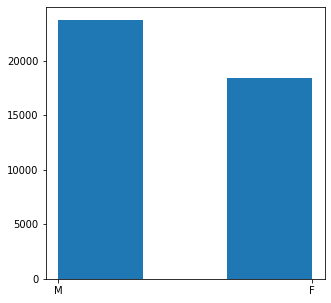

Male Patients: 23724
Female Patients: 18396


In [18]:
plt.figure(figsize=(5,5))
plt.hist(df.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, df.Patient_Gender == "M")))
female_patiens = len(list(filter(None, df.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)

### Age distribution

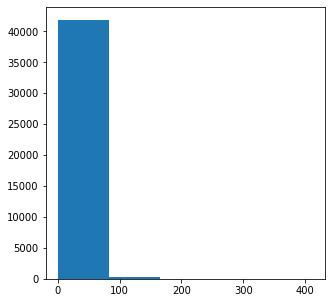

In [19]:

plt.figure(figsize=(5,5))
plt.hist(df.Patient_Age, bins = 5)
plt.show()

In [20]:
max_age = np.max(df.Patient_Age)
max_age

411

Looks loke the max age is 411, so this is clearly an error. It also looks like that arround 90 there is a huge dropoff. 

In [21]:
patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
patiens_over_90

35

Because there is only a small number of patients over 90, let's remove them from the dataset.

In [22]:
is_not_over_90 =  df.Patient_Age < 91
df = df[is_not_over_90]

patiens_over_90 = len(list(filter(None, df.Patient_Age > 90)))
patiens_over_90

0

Min Age: 1
Max Age: 90
Mean Age: 46.92959486753
Median Age: 49.0



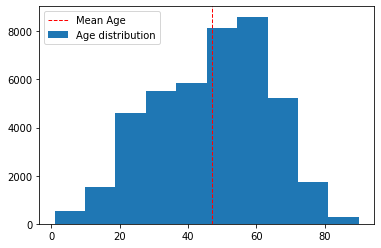

In [23]:
mean_age = np.mean(df.Patient_Age)
median_age = np.median(df.Patient_Age)
min_age = np.min(df.Patient_Age)
max_age = np.max(df.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(df.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

The resulting dataset consists of patients from the age of 1 to 90. The mean age ist 47, the median age is 49.

### Case distribution

[Text(0, 0.5, 'Number of Images with Label')]

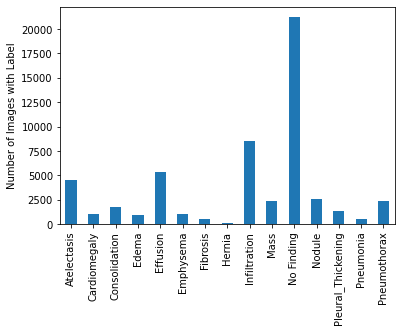

In [25]:
ax = df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The most common value is "No finding". The most common disease is "Infiltration". Pneumonia is only found in a few patients.

Now let's look with a little bit more detail on the patients which do have Pneumonia

In [28]:
d_pneumonia = df.copy()
has_pneumonia =  d_pneumonia['Pneumonia'] == 1
d_pneumonia = d_pneumonia[has_pneumonia]

d_pneumonia.shape

(539, 20)

### Gender distribution of Pneumonia patients

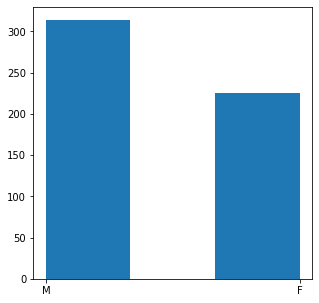

Male Patients: 314
Female Patients: 225
1.4 male to female patients


In [30]:
plt.figure(figsize=(5,5))
plt.hist(d_pneumonia.Patient_Gender, bins = 3)
plt.show()

male_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "M")))
female_patiens = len(list(filter(None, d_pneumonia.Patient_Gender == "F")))
print("Male Patients:", male_patiens)
print("Female Patients:", female_patiens)
print(round(male_patiens / female_patiens, 2), "male to female patients")

Min Age: 3
Max Age: 87
Mean Age: 44.01298701298701
Median Age: 45.0



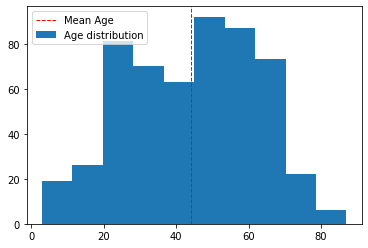

In [32]:
mean_age = np.mean(d_pneumonia.Patient_Age)
median_age = np.median(d_pneumonia.Patient_Age)
min_age = np.min(d_pneumonia.Patient_Age)
max_age = np.max(d_pneumonia.Patient_Age)

print("Min Age:", min_age)
print("Max Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("")

fig,ax = plt.subplots()

data_line = ax.hist(d_pneumonia.Patient_Age, label='Age distribution')
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

Patients with Pneumonia tend to be a few years younger than the global population. People at arround 50-65 are most likely to have Pneumonia.

## Image data assessments

In [34]:
## helper function standardize the image
def standardize_image(imageData):
    # Find the mean and std dev intensity values of the image, and standerdize it
    mean_intensity = np.mean(imageData)
    std_intensity = np.std(imageData)
    new_img = imageData.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    return new_img

## helper function to print the image and the intensity distribution
def image_distribution(image):
    f = plt.figure()
    f.set_figwidth(10)
    
    # standardize the image data
    image = standardize_image(image)
    
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(image, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(image.ravel(), bins = 256)
    
    plt.show()

### Pneumonia Samples

Image Name 00026619_000.png


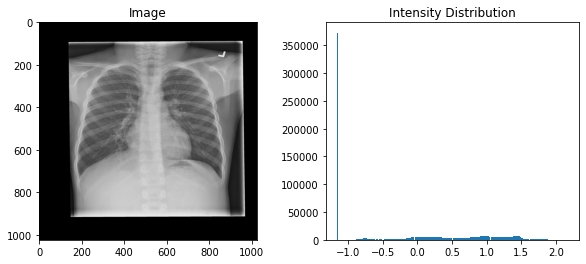

In [44]:
img = df[df['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

Image Name 00019176_067.png


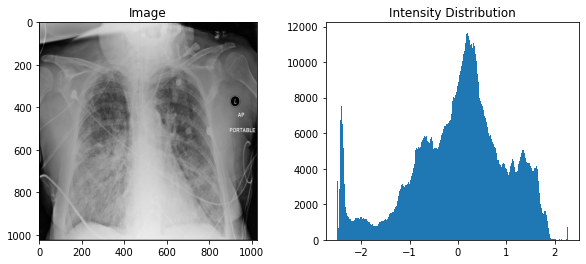

In [45]:
img = df[df['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

Image Name 00026389_002.png


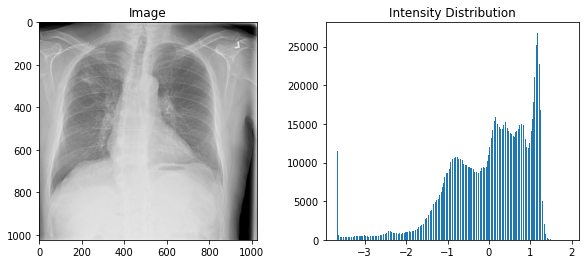

In [46]:
img = df[df['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

### Non Pneumonia Samples

Image Name 00025362_004.png


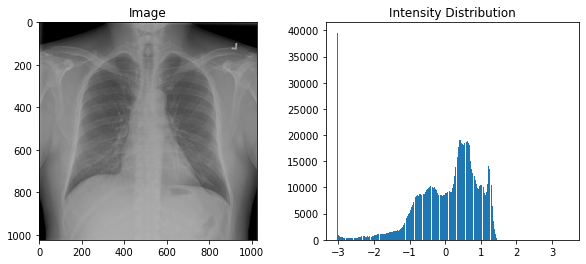

In [49]:
img = df[df['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

Image Name 00025527_009.png


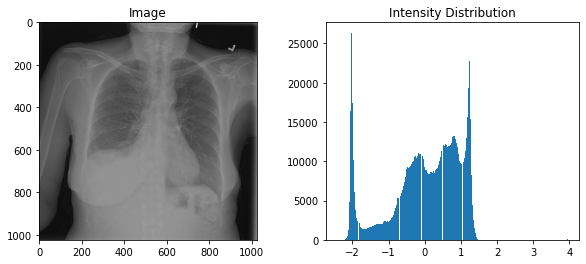

In [50]:
img = df[df['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

Image Name 00024966_000.png


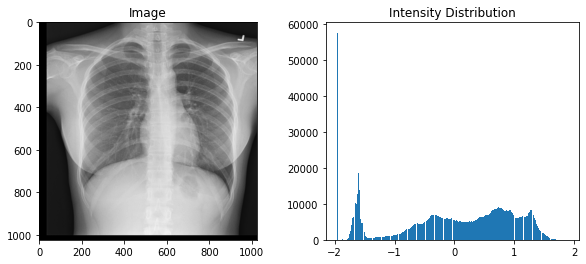

In [51]:
img = df[df['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', img)
img = io.imread(all_image_paths[img])
image_distribution(img)

When analyzing the images of pneumonia vs. non-pneumonia patients, it appears that the intensity distribution of both cases follows more a normal distribution. As already stated in the README.md of the Kaggle dataset, the diagnosis of pneumonia from chest X-rays is very difficult.